<a href="https://colab.research.google.com/github/SARA3SAEED/aws-ML/blob/main/3_abu_part_01_Embeddings_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers==3.0.1 datasets
!pip install Pympler==1.1

## Download Dataset

In [ ]:
from datasets import load_dataset
from tqdm.auto import tqdm
import pandas as pd

ds = load_dataset("Cohere/wikipedia-22-12", "ar", streaming=True, trust_remote_code=True)

In [ ]:
max_titles = 500
all_titles = set()
collected_recs = []

progress_bar = tqdm()
for rec in ds["train"]:
    if rec["title"] not in all_titles:
        all_titles.add(rec["title"])
        progress_bar.update(1)

    if len(all_titles) == max_titles:
        break

    collected_recs.append(rec)

In [ ]:
collected_df = pd.DataFrame(collected_recs)
collected_df.to_csv("collected_data.csv", index=False)

## Outliers Filters

In [ ]:
import pandas as pd

collected_df = pd.read_csv("collected_data.csv")

collected_df = collected_df.drop(columns=["url", "wiki_id", "views", "paragraph_id", "langs"])
print(collected_df.shape)

(46564, 3)


In [ ]:
collected_df.sample(2).head()

,id,title,text
34837,34837,نسوية,تلاحظ كاثرين روتنبرغ أن سبب وجود النسوية الليب...
12297,12297,أبجدية عربية,تتشابه بعض الأحرف في الأبجدية العربية ببعضها، ...


In [ ]:
# ===== Collecte text length
collected_df["text_length"] = collected_df["text"].apply(lambda text: len(text.strip()))
collected_df["text_length"].describe()

,text_length
count,46564.000000
mean,512.716734
std,358.495835
min,101.000000
25%,271.000000
50%,427.000000
75%,650.000000
max,5477.000000


In [ ]:
cleaned_collected_df = collected_df[ collected_df["text_length"] <= 1500 ]
cleaned_collected_df["text_length"].describe()

,text_length
count,45563.000000
mean,480.568948
std,279.710852
min,101.000000
25%,267.000000
50%,420.000000
75%,630.000000
max,1500.000000


In [ ]:
cleaned_collected_df = cleaned_collected_df.sample(frac=1, random_state=101)

## Embed Documents

#### Install Ollama Embedding Client

In [ ]:
# install ollama
!pip install ollama==0.3.2
!curl https://ollama.ai/install.sh | sh

In [ ]:
ollama_model_id = "paraphrase-multilingual"

In [ ]:
# run ollama server
!nohup ollama serve &
!sleep 8 && tail nohup.out

In [ ]:
# !pkill -f ollama
!ollama pull {ollama_model_id}

In [ ]:
!nohup ollama run {ollama_model_id} &
!sleep 8 && tail nohup.out

#### Evaluate Ollama Embedding

In [ ]:
import torch
import ollama
from tqdm.auto import tqdm
from sentence_transformers.util import semantic_search, cos_sim

In [ ]:
sample_corpus = cleaned_collected_df["text"].values[:50]

sample_embeddings = [
    ollama.embeddings(
        model='paraphrase-multilingual',
        prompt=text
    )['embedding']
    for text in tqdm(sample_corpus)
]

question_text = "متى عقد الحلفاء المعاهدة التي ادت الى السلم مع الدولة الألمانية؟" # record:15
question_embedding =  ollama.embeddings(
                        model='paraphrase-multilingual',
                        prompt=question_text,
                    )['embedding']

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
sample_embeddings = torch.FloatTensor(sample_embeddings)
question_embedding = torch.FloatTensor([question_embedding])

In [ ]:
similar_documents = semantic_search(
    query_embeddings=question_embedding,
    corpus_embeddings=sample_embeddings,
    top_k=10,
)

In [ ]:
for document in similar_documents[0]:
    _id = document["corpus_id"]
    print("Score", document["score"])
    print(sample_corpus[_id])
    print("="*30)

Score 0.7565121054649353
«كان يجب على الولايات المتحدة أن تفكر مليًا في مصالحها، وألا تنخرط في الحرب العالمية الأولى. فإذا لم تخض الحرب، لكان عقد الحلفاء السلام مع ألمانيا في ربيع 1917. فلو كان السلام خيارنا، لما كان الانهيار الذي حل بروسيا، والذي تلته الشيوعية، ولا كانت حلت الفاشية بإيطاليا، ولما أصبحت ألمانيا طرفًا في معاهدة فرساي التي عظمت من وجود النازية في ألمانيا».
Score 0.5259615182876587
مصطلح الحل النهائي أو حل أخير تم استعماله لأول مرة من قبل أدولف أيخمان والذي أشرف على عمليات الهولوكوست وتمت محاكمته وإعدامه من قبل محكمة إسرائيلية في 1 يونيو 1962 في سجن الرملة. تمت مناقشة خطة الحل النهائي في مؤتمر داخلي للحزب النازي عقد في منطقة وانسي جنوب غرب برلين في 20 يناير 1942 والذي نوقشت فيه آلية إبادة يهود أوروبا، وحضر ذلك الاجتماع هينريك هيملر أيضا والذي كان من أقوى رجال أدولف هتلر وأكثرهم شراسة. ونص مختصر محضر الاجتماع أن الأسلوب السابق في تشجيع اليهود على الهجرة من ألمانيا قد تم تغييره إلى الاستبعاد القسري.
Score 0.43884581327438354
كانت تركيا منتجًا مهمًا للكروميت، وهو مكون رئيسي 

In [ ]:
print("Size of Index:", asizeof.asizeof(sample_embeddings), "bytes")

## Test Sbert Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search, cos_sim
import torch
from tqdm.auto import tqdm
from pympler import asizeof

# Check more
# https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html?highlight=sentencetransformer#sentence_transformers.SentenceTransformer

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
normalize_embeddings = True
precision = "int8" # float32

In [ ]:
sample_corpus = cleaned_collected_df["text"].values[:50]

sample_embeddings = [
    model.encode(text, normalize_embeddings=normalize_embeddings).tolist()
    for text in tqdm(sample_corpus)
]

question_text = "متى عقد الحلفاء المعاهدة التي ادت الى السلم مع الدولة الألمانية؟"
question_embedding =  model.encode(question_text, normalize_embeddings=normalize_embeddings).tolist()

In [ ]:
sample_embeddings = torch.FloatTensor(sample_embeddings)
question_embedding = torch.FloatTensor([question_embedding])

In [ ]:
similar_documents = semantic_search(
    query_embeddings=question_embedding,
    corpus_embeddings=sample_embeddings,
    top_k=10,
)

print("Size of Index:", asizeof.asizeof(sample_embeddings), "bytes")
print("="*30)

for document in similar_documents[0]:
    _id = document["corpus_id"]
    print("Score", document["score"])
    print(sample_corpus[_id])
    print("="*30)

Score 0.6488306522369385
«كان يجب على الولايات المتحدة أن تفكر مليًا في مصالحها، وألا تنخرط في الحرب العالمية الأولى. فإذا لم تخض الحرب، لكان عقد الحلفاء السلام مع ألمانيا في ربيع 1917. فلو كان السلام خيارنا، لما كان الانهيار الذي حل بروسيا، والذي تلته الشيوعية، ولا كانت حلت الفاشية بإيطاليا، ولما أصبحت ألمانيا طرفًا في معاهدة فرساي التي عظمت من وجود النازية في ألمانيا».
Score 0.6129641532897949
مصطلح الحل النهائي أو حل أخير تم استعماله لأول مرة من قبل أدولف أيخمان والذي أشرف على عمليات الهولوكوست وتمت محاكمته وإعدامه من قبل محكمة إسرائيلية في 1 يونيو 1962 في سجن الرملة. تمت مناقشة خطة الحل النهائي في مؤتمر داخلي للحزب النازي عقد في منطقة وانسي جنوب غرب برلين في 20 يناير 1942 والذي نوقشت فيه آلية إبادة يهود أوروبا، وحضر ذلك الاجتماع هينريك هيملر أيضا والذي كان من أقوى رجال أدولف هتلر وأكثرهم شراسة. ونص مختصر محضر الاجتماع أن الأسلوب السابق في تشجيع اليهود على الهجرة من ألمانيا قد تم تغييره إلى الاستبعاد القسري.
Score 0.5917273759841919
كانت تركيا منتجًا مهمًا للكروميت، وهو مكون رئيسي ف

### Embeddding Qualitative Evaluation

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search, cos_sim
import torch
from tqdm.auto import tqdm
from pympler import asizeof

# Check more
# https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html?highlight=sentencetransformer#sentence_transformers.SentenceTransformer

# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# model = SentenceTransformer('sentence-transformers/LaBSE')
model = SentenceTransformer('AbderrahmanSkiredj1/Arabic_text_embedding_for_sts')

normalize_embeddings = True

In [ ]:
sample_corpus = cleaned_collected_df["text"].values[:50]

sample_embeddings = [
    model.encode(text, normalize_embeddings=normalize_embeddings).tolist()
    for text in tqdm(sample_corpus)
]

sample_embeddings = torch.FloatTensor(sample_embeddings)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
queries_text = [
    "متى عقد الحلفاء المعاهدة التي ادت الى السلم مع الدولة الألمانية؟",
    "من كان يحضر اجتماع المعاهدةالتي عقدها الحلفاء للسلام مع ألمانيا؟",
    "اي الأطعمة اشهر في المانيا؟",
    "المانيا معاهدة المانيا حرب ألمانيا سلام ألمانيا ألمانيا",
    "اين يمكنني ان اعثر على غطاء وردي لجوالي؟",
    "السلام عليكم"
]

queries_embeddings = model.encode(queries_text, normalize_embeddings=normalize_embeddings)

In [ ]:
for text, vec in zip(queries_text, queries_embeddings):
    print("Text:")
    print(text)
    print(":"*5)

    similar_documents = semantic_search(
        query_embeddings=vec,
        corpus_embeddings=sample_embeddings,
        top_k=2,
    )

    for document in similar_documents[0]:
        _id = document["corpus_id"]
        print("Score", document["score"])
        print(sample_corpus[_id])
        print("="*30)

    print("*"*80)
    print("*"*80)

Text:
متى عقد الحلفاء المعاهدة التي ادت الى السلم مع الدولة الألمانية؟
:::::
Score 0.4765843152999878
«كان يجب على الولايات المتحدة أن تفكر مليًا في مصالحها، وألا تنخرط في الحرب العالمية الأولى. فإذا لم تخض الحرب، لكان عقد الحلفاء السلام مع ألمانيا في ربيع 1917. فلو كان السلام خيارنا، لما كان الانهيار الذي حل بروسيا، والذي تلته الشيوعية، ولا كانت حلت الفاشية بإيطاليا، ولما أصبحت ألمانيا طرفًا في معاهدة فرساي التي عظمت من وجود النازية في ألمانيا».
Score 0.3587024211883545
كانت تركيا منتجًا مهمًا للكروميت، وهو مكون رئيسي في صناعة الفولاذ المقاوم للصدأ والطوب المقاوم للصهر، وكان وصول ألمانيا إليه محدودًا. كانت القضية الرئيسية في مفاوضات تركيا مع كلا الجانبين هي بيع الكروميت لألمانيا أو للحلفاء. كان لدى الحلفاء إمكانية الوصول إلى مصادر أخرى واشتروا الكروميت بشكل أساسي من أجل منع بيعه إلى ألمانيا. أوقفت تركيا مبيعاتها لألمانيا في أبريل 1944 وقطعت العلاقات في أغسطس. أعلنت تركيا الحرب على دول المحور في فبراير 1945، بعد أن وجه الحلفاء دعوتهم للاجتماع الافتتاحي للأمم المتحدة (جنبًا إلى جنب مع د

In [ ]:
for text, vec in zip(queries_text, queries_embeddings):
    print("Text:")
    print(text)
    print(":"*5)

    similar_documents = semantic_search(
        query_embeddings=vec,
        corpus_embeddings=sample_embeddings,
        top_k=2,
    )

    for document in similar_documents[0]:
        _id = document["corpus_id"]
        print("Score", document["score"])
        print(sample_corpus[_id])
        print("="*30)

    print("*"*80)
    print("*"*80)

Text:
متى عقد الحلفاء المعاهدة التي ادت الى السلم مع الدولة الألمانية؟
:::::
Score 0.5178075432777405
«كان يجب على الولايات المتحدة أن تفكر مليًا في مصالحها، وألا تنخرط في الحرب العالمية الأولى. فإذا لم تخض الحرب، لكان عقد الحلفاء السلام مع ألمانيا في ربيع 1917. فلو كان السلام خيارنا، لما كان الانهيار الذي حل بروسيا، والذي تلته الشيوعية، ولا كانت حلت الفاشية بإيطاليا، ولما أصبحت ألمانيا طرفًا في معاهدة فرساي التي عظمت من وجود النازية في ألمانيا».
Score 0.3628353476524353
كانت تركيا منتجًا مهمًا للكروميت، وهو مكون رئيسي في صناعة الفولاذ المقاوم للصدأ والطوب المقاوم للصهر، وكان وصول ألمانيا إليه محدودًا. كانت القضية الرئيسية في مفاوضات تركيا مع كلا الجانبين هي بيع الكروميت لألمانيا أو للحلفاء. كان لدى الحلفاء إمكانية الوصول إلى مصادر أخرى واشتروا الكروميت بشكل أساسي من أجل منع بيعه إلى ألمانيا. أوقفت تركيا مبيعاتها لألمانيا في أبريل 1944 وقطعت العلاقات في أغسطس. أعلنت تركيا الحرب على دول المحور في فبراير 1945، بعد أن وجه الحلفاء دعوتهم للاجتماع الافتتاحي للأمم المتحدة (جنبًا إلى جنب مع د

### MTEB Top STS Leaderboard

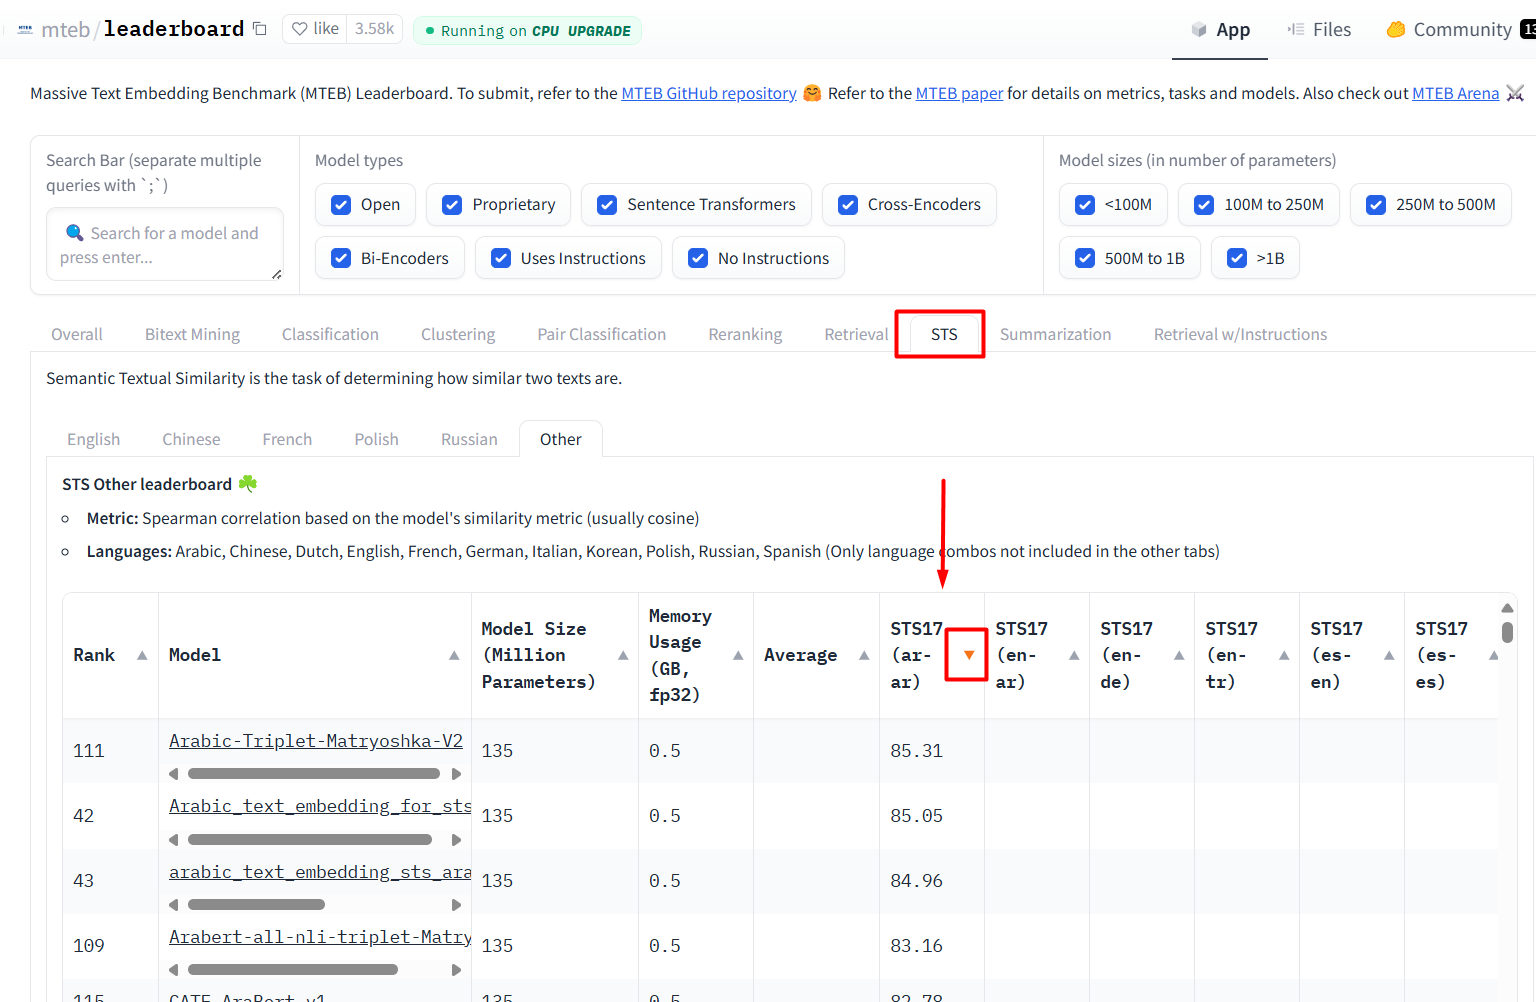